In [1]:
import torch
import torchvision
from model.abp_sc import ABPSC
from datasets import get_dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_loader, (image_size, channel_size) = get_dataset('fashion', 32)

Extracting ./fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw



Extracting ./fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw


Extracting ./fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
num_epochs = 30
hidden_size = 400
kernel_size = 64

latent_size = 200
alpha = 0.01
learning_rate = 0.01
langevin_steps = 10
noise_variance = 0.3
slab_variance = 0.1
langevin_stepsize = 0.1
linear = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
abpsc = ABPSC(latent_size, alpha, learning_rate, langevin_steps, noise_variance, slab_variance, langevin_stepsize, device)

In [5]:
abpsc.train(train_loader, num_epochs, hidden_size, kernel_size, channel_size, image_size, linear)


Interation: 0
Loss:  6099896.837646484
Average Z Sum: tensor(9.2816, grad_fn=<DivBackward0>)
Iteration: 1
Loss 5364953.165649414
Average Z Sum: tensor(11.1379, grad_fn=<DivBackward0>)
Iteration: 2
Loss 5256141.494140625
Average Z Sum: tensor(11.9865, grad_fn=<DivBackward0>)
Iteration: 3
Loss 5212361.30090332
Average Z Sum: tensor(12.6783, grad_fn=<DivBackward0>)
Iteration: 4
Loss 5188309.282714844
Average Z Sum: tensor(13.1602, grad_fn=<DivBackward0>)
Interation: 5
Loss:  5143149.993774414
Average Z Sum: tensor(13.5437, grad_fn=<DivBackward0>)
Iteration: 6
Loss 5131047.976196289
Average Z Sum: tensor(13.9083, grad_fn=<DivBackward0>)
Iteration: 7
Loss 5112250.602661133
Average Z Sum: tensor(14.2692, grad_fn=<DivBackward0>)
Iteration: 8
Loss 5105151.582641602
Average Z Sum: tensor(14.4681, grad_fn=<DivBackward0>)
Iteration: 9
Loss 5106287.830322266
Average Z Sum: tensor(14.6576, grad_fn=<DivBackward0>)
Interation: 10
Loss:  5090297.134887695
Average Z Sum: tensor(14.8448, grad_fn=<DivBa

In [6]:
def plot_reconstruction(image, z):
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
  img = torchvision.utils.make_grid(image.cpu()).detach().numpy()
  ax0.imshow(np.transpose(img, (1,2,0)))
  ax0.set_title('Input Image', fontsize=20)
    
  ax1.bar(np.arange(z.shape[0]), height=z.cpu().detach().numpy(), width=1/7, align='center')
  ax1.stem(np.arange(z.shape[0]), z.cpu().detach().numpy(), markerfmt=' ', use_line_collection=True)
  ax1.axhline(y=0)
  ax1.set_ylim(z.min().cpu().detach().numpy(), z.max().cpu().detach().numpy())
  ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % (z.shape[0], alpha), fontsize=20)
    
  img = abpsc.generator(z.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()
  ax2.imshow(np.transpose(img, (1,2,0)))
  ax2.set_title('Decoded Image', fontsize=20)

In [7]:
# Get image and latent data
image, _ = iter(train_loader).next()
z = abpsc.get_latent()

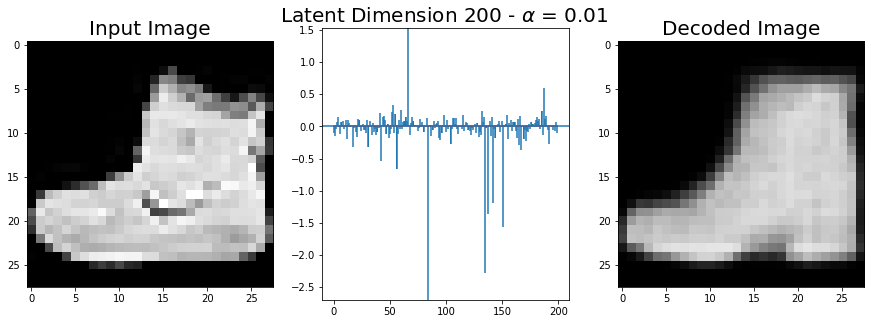

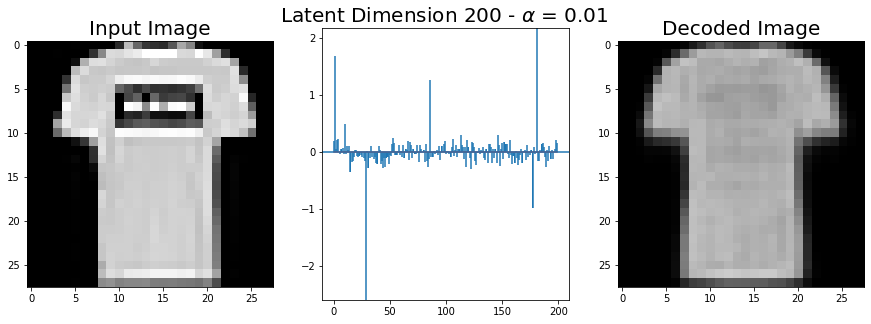

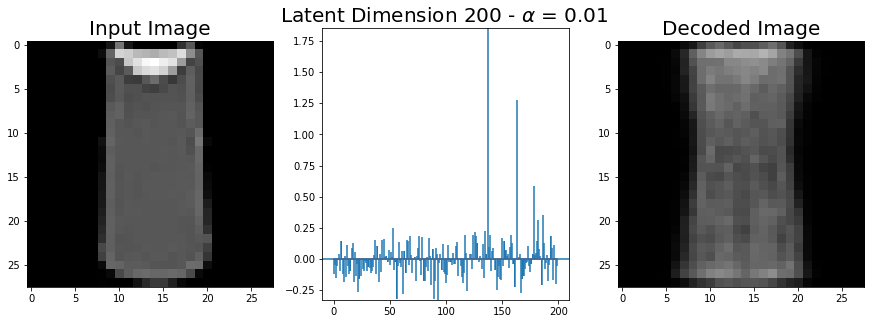

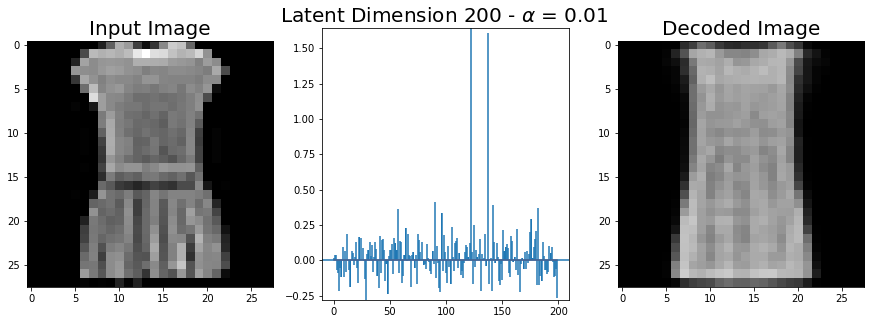

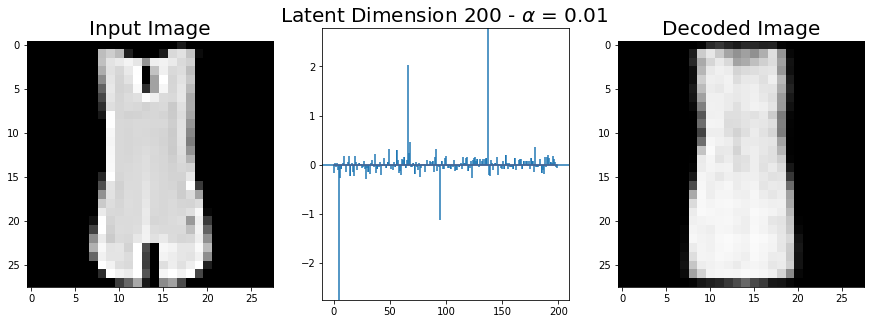

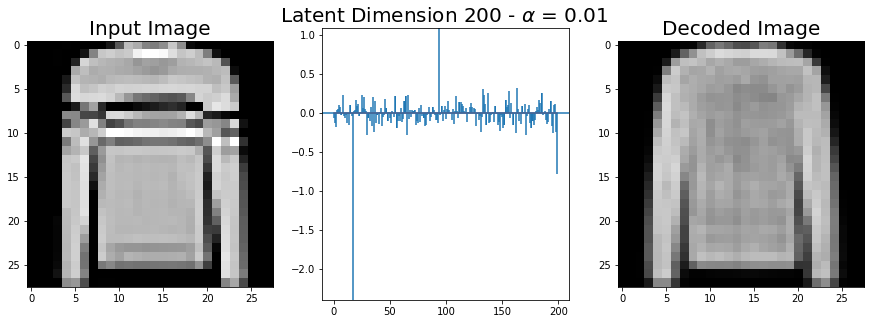

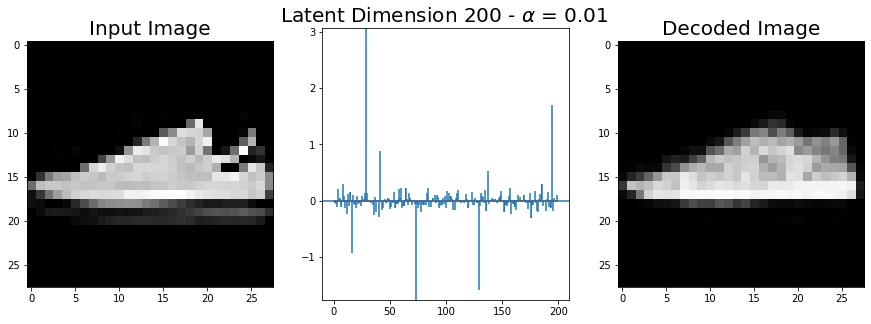

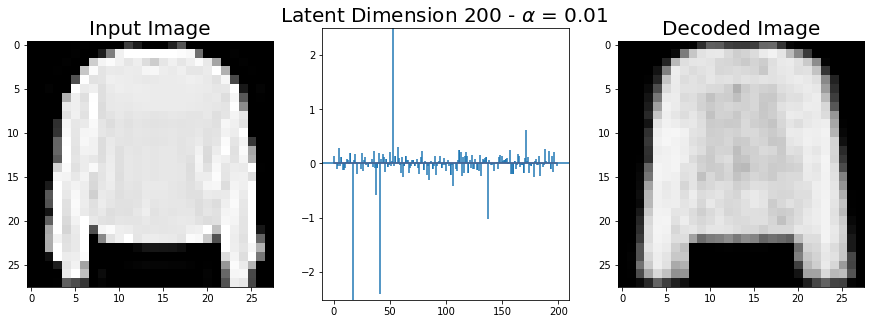

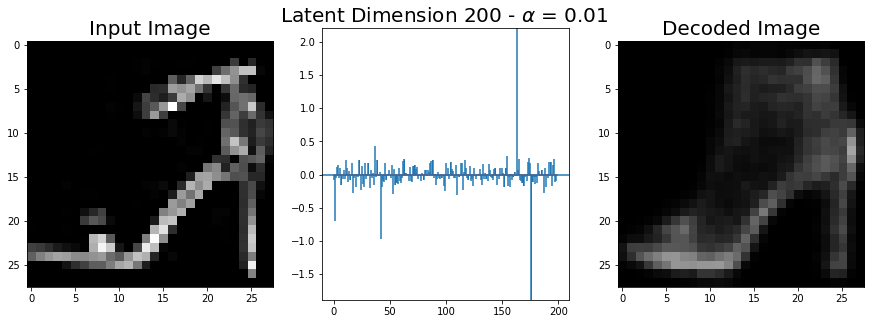

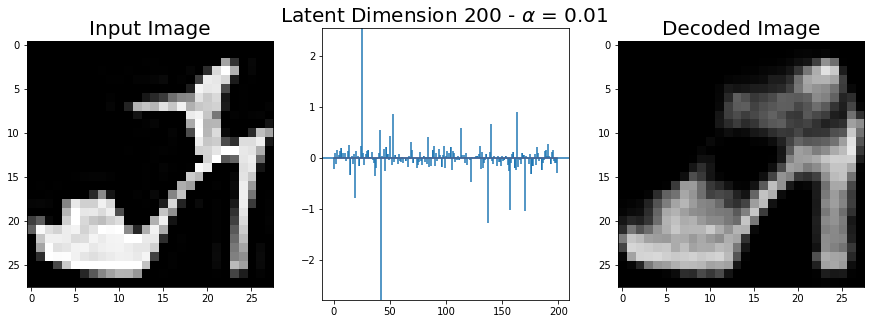

In [8]:
# Plot 10 reconstructed images
for i in range(10):
  plot_reconstruction(image[i], z[i])

In [9]:
def plot_alter_latent(z):
  z_max_index = torch.argmax(torch.abs(z)).cpu().detach()
  fig, ax = plt.subplots(nrows=2, ncols = 3 , figsize=(21,14))

  # Original Latent 
  ax[0, 0].bar(np.arange(z.shape[0]) , height=z.cpu().detach().numpy() , width=0.2)
  ax[0, 0].scatter(np.arange(z.shape[0]) , z.cpu().detach().numpy(), color='blue')
  ax[0, 0].scatter(z_max_index , z[z_max_index].cpu().detach().numpy(), color='red')
  ax[0, 0].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z.shape[0], alpha) , fontsize=20)
  ax[0, 0].set_ylim(-torch.abs(z).max().cpu().detach().numpy()-0.1, torch.abs(z).max().cpu().detach().numpy()+0.1)

  img = abpsc.generator(z.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()
  ax[1, 0].imshow(np.transpose(img, (1, 2, 0)))
  ax[1, 0].set_title('Reconstructed Image', fontsize=20)
  # Halved Latent Element
  z_new = z.clone()
  z_new[z_max_index] = z_new[z_max_index] / 2

  ax[0, 1].bar(np.arange(z_new.shape[0]) , height=z_new.cpu().detach().numpy() , width=0.2)
  ax[0, 1].scatter(np.arange(z_new.shape[0]) , z_new.cpu().detach().numpy(), color='blue')
  ax[0, 1].scatter(z_max_index , z_new[z_max_index].cpu().detach().numpy(), color='red')
  ax[0, 1].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z_new.shape[0], alpha) , fontsize=20)
  ax[0, 1].set_ylim(-torch.abs(z).max().cpu().detach().numpy()-0.1, torch.abs(z).max().cpu().detach().numpy()+0.1)

  img = abpsc.generator(z_new.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()  
  ax[1, 1].imshow(np.transpose(img, (1, 2, 0)))
  ax[1, 1].set_title('Reconstructed Image', fontsize=20)

  # Negative Latent Element
  z_new[z_max_index] = z_new[z_max_index] * -1

  ax[0, 2].bar(np.arange(z_new.shape[0]) , height=z_new.cpu().detach().numpy() , width=0.2)
  ax[0, 2].scatter(np.arange(z_new.shape[0]) , z_new.cpu().detach().numpy(), color='blue')
  ax[0, 2].scatter(z_max_index , z_new[z_max_index].cpu().detach().numpy(), color='red')
  ax[0, 2].set_title(r"Latent Dimension %d - $\alpha$ = %.2f "%(z_new.shape[0], alpha) , fontsize=20)
  ax[0, 2].set_ylim(-torch.abs(z).max().cpu().detach().numpy()-0.1, torch.abs(z).max().cpu().detach().numpy()+0.1)

  img = abpsc.generator(z_new.view(1, latent_size))
  img = torchvision.utils.make_grid(img.view(1, channel_size, image_size, image_size).cpu()).detach().numpy()  
  ax[1, 2].imshow(np.transpose(img, (1, 2, 0)))
  ax[1, 2].set_title('Reconstructed Image', fontsize=20)

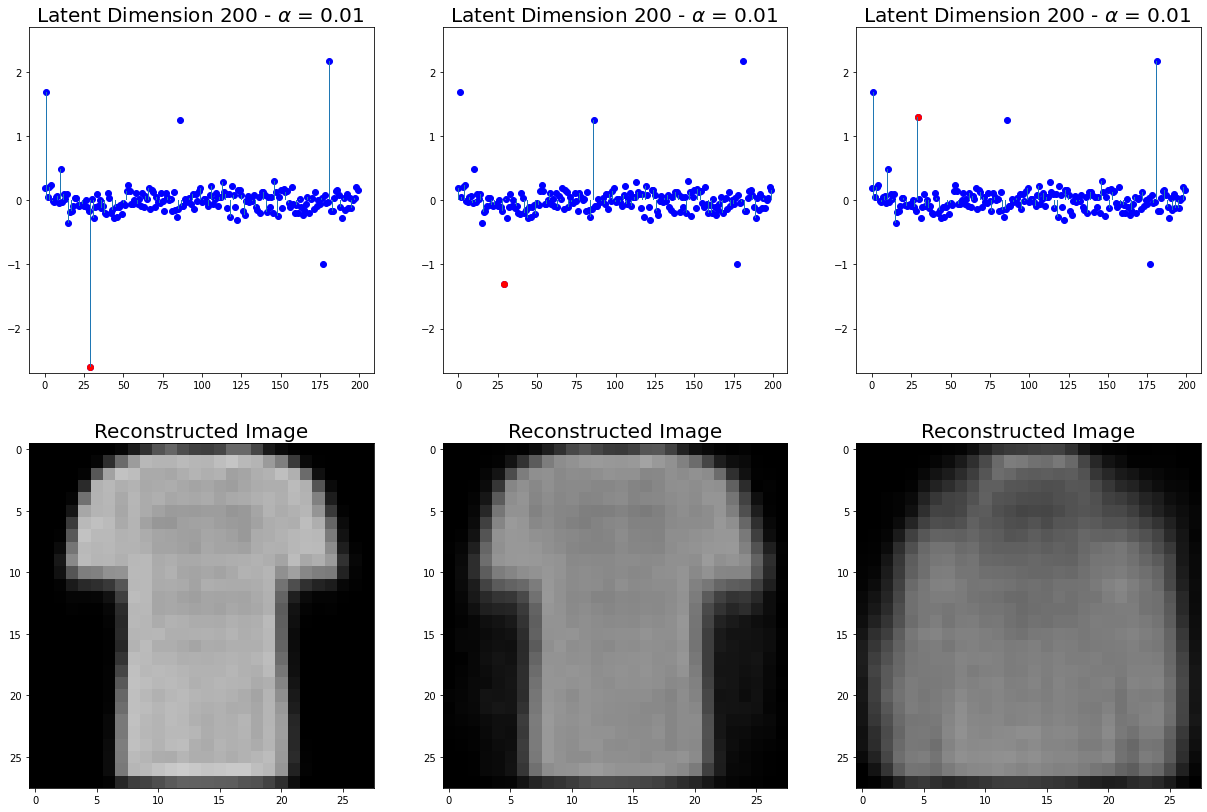

In [11]:
plot_alter_latent(z[1])

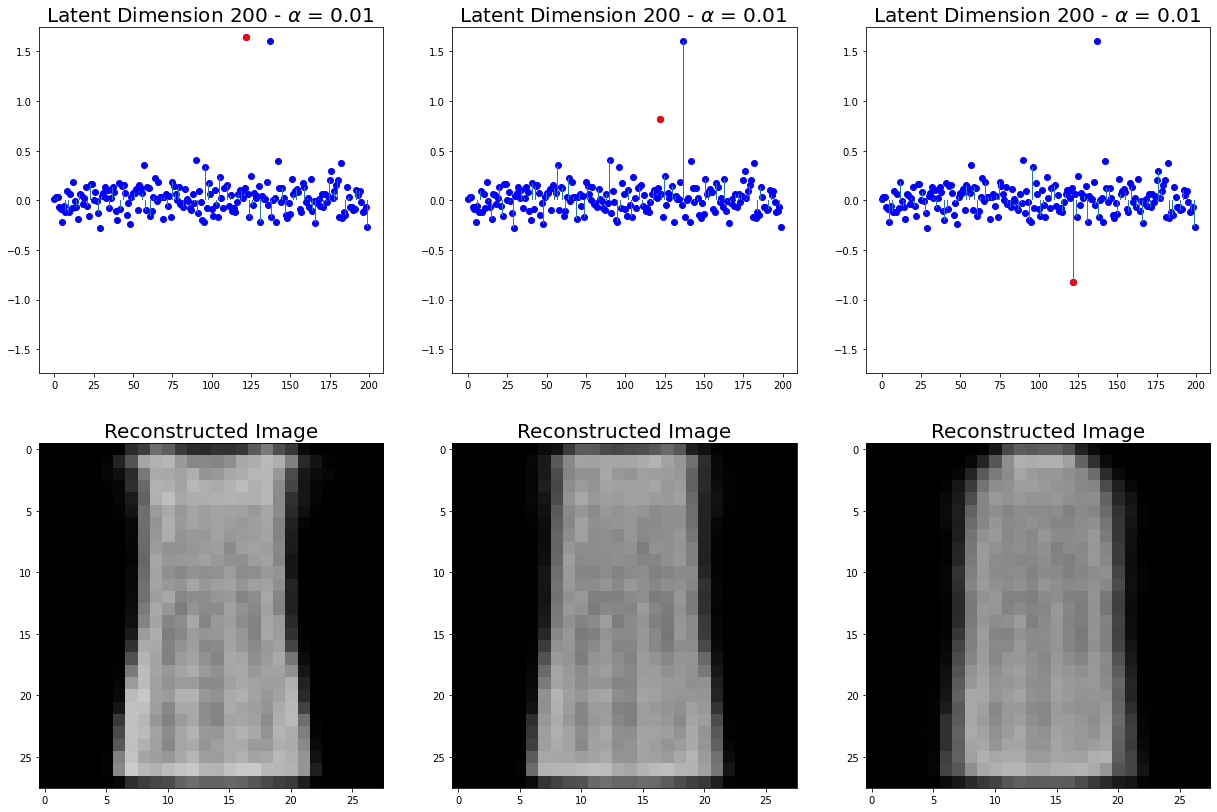

In [13]:
plot_alter_latent(z[3])

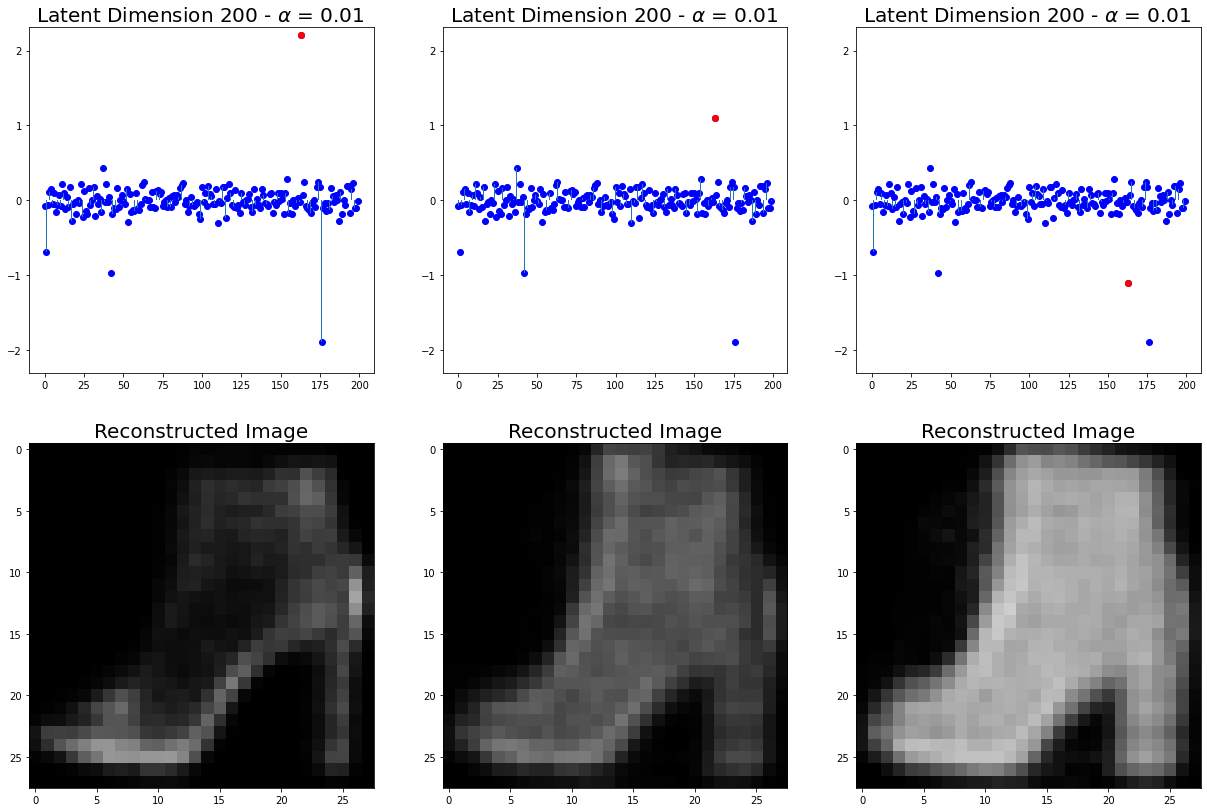

In [18]:
plot_alter_latent(z[8])

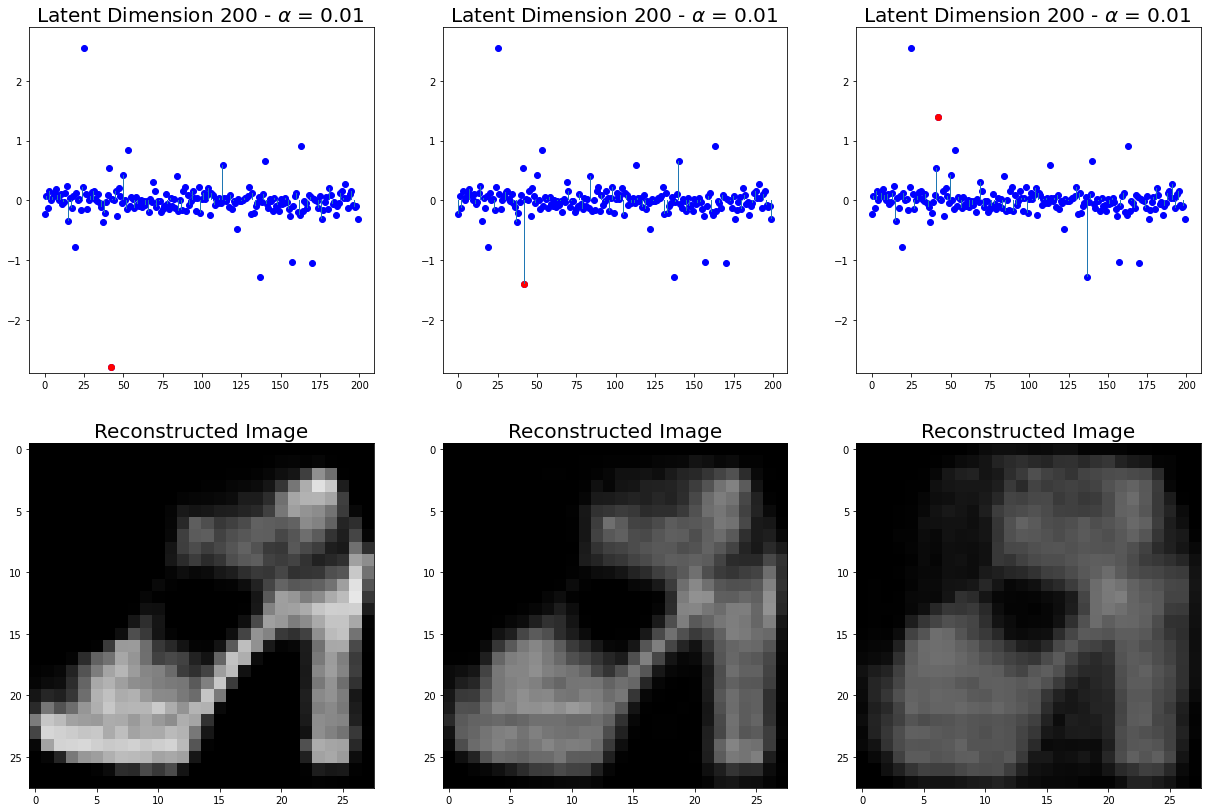

In [19]:
plot_alter_latent(z[9])

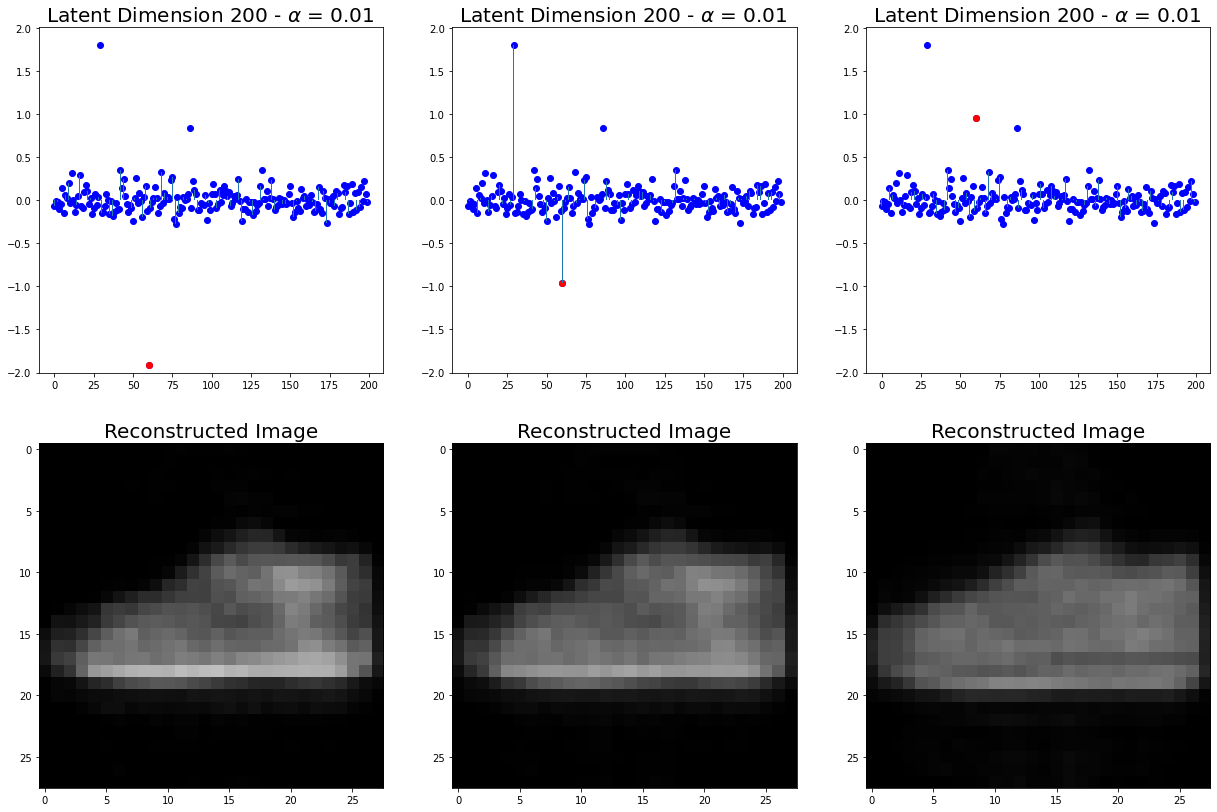

In [23]:
plot_alter_latent(z[13])

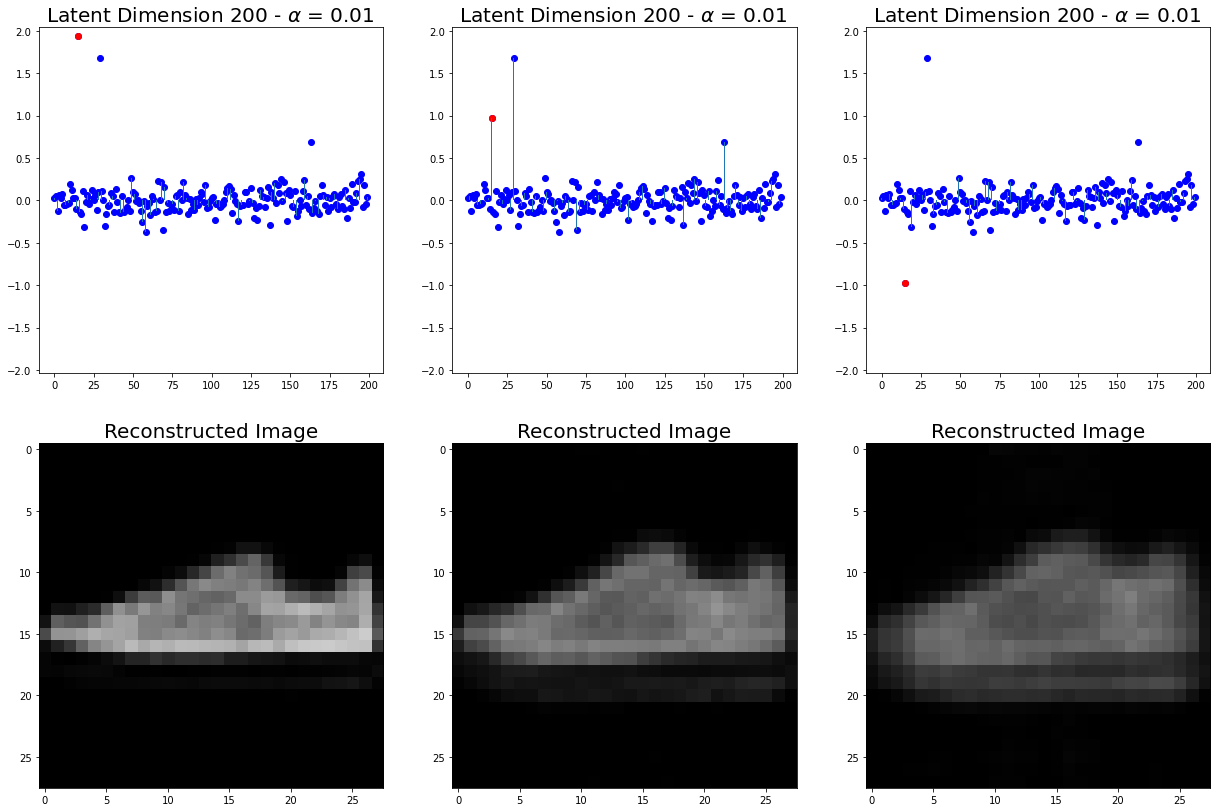

In [24]:
plot_alter_latent(z[14])

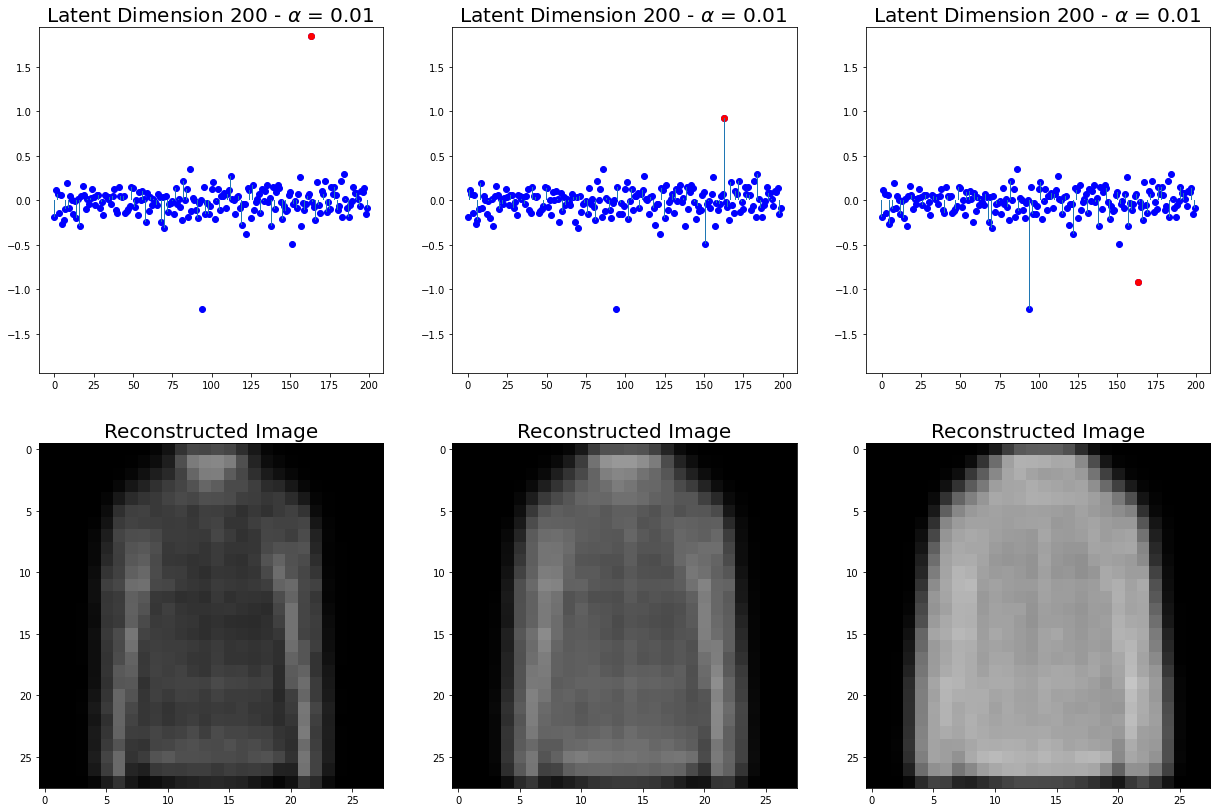

In [29]:
plot_alter_latent(z[19])

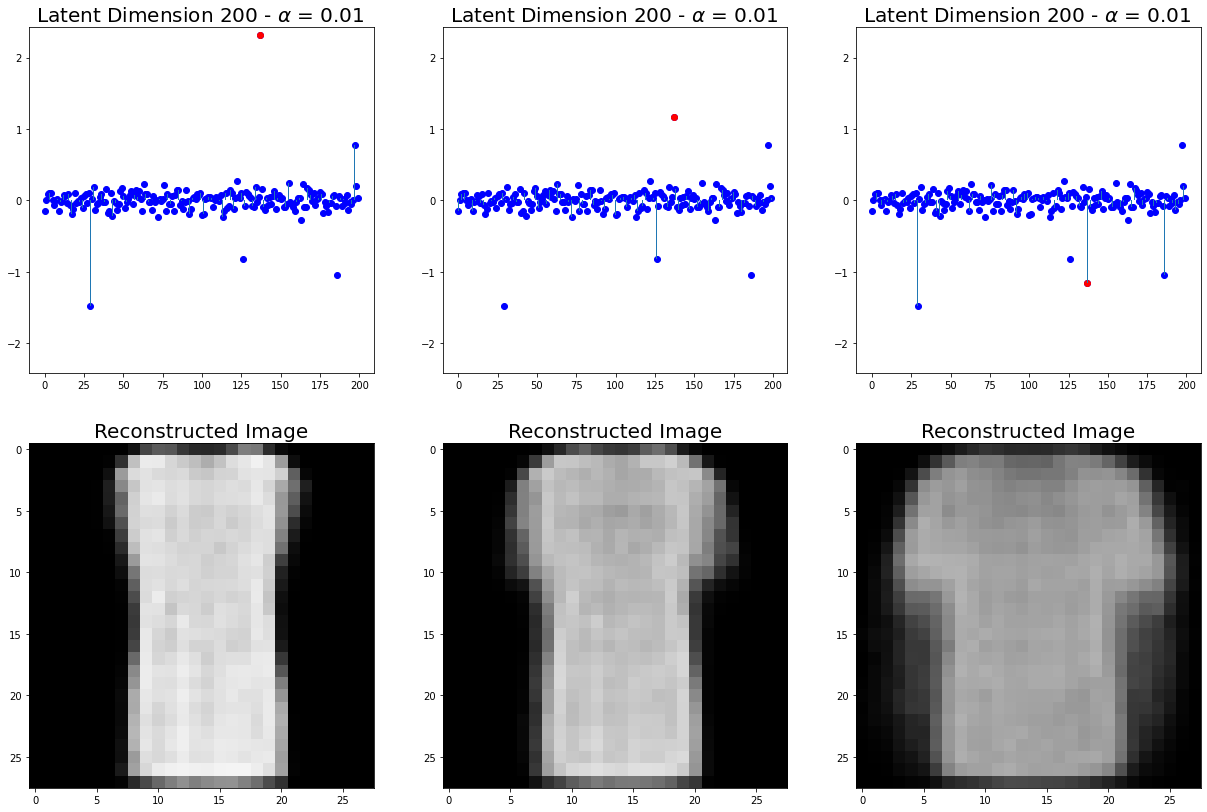

In [30]:
plot_alter_latent(z[20])

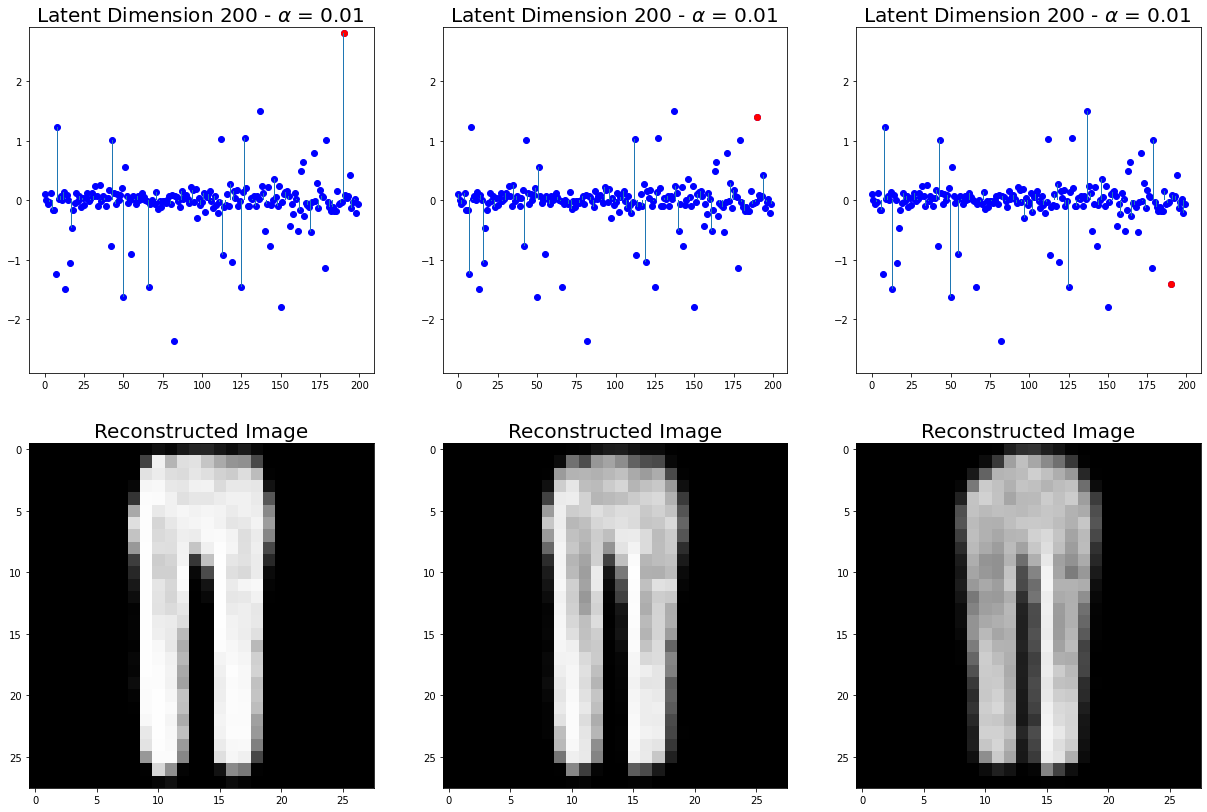

In [31]:
plot_alter_latent(z[21])

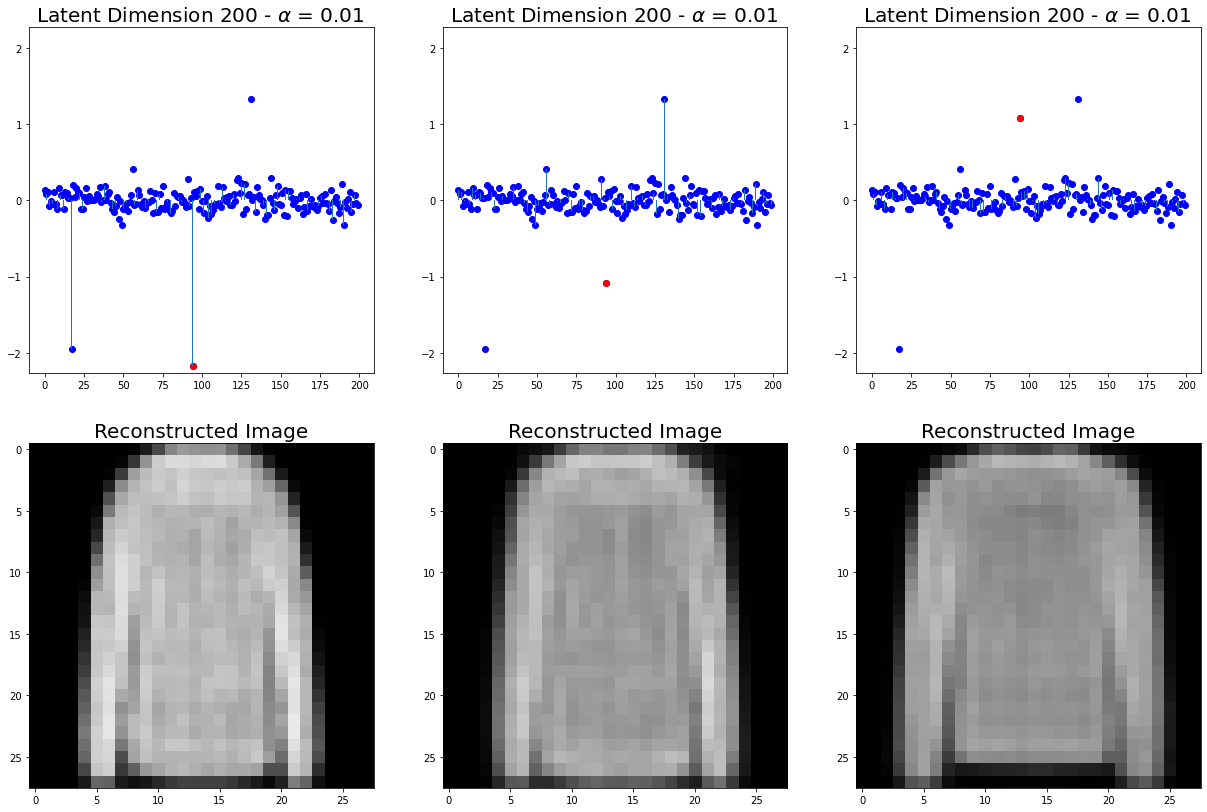

In [34]:
plot_alter_latent(z[24])